In [96]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

## Implementing HACI.

What do we do about the score funciton?

- What is the purpose of the score function?
    - It just provides a method for comparing performance between all datapoints. This isnt always obvious but in regression it is.
    - Our current method we take the absolute value, this does not allow us to look at the upper and lower.
    - If we changed the absolute value how would this change?
        - It removes the implicit symmetric assumption of the distribution. However it decreases the effective lookback window.
        As half of the data will be below (probably).


Current conclusion:
- It is sufficent to just use the difference as the score function.  

How to deal with the data as it now got three componets?
- Currently it doesn't matter as our xpred is just the last value but you want it to deal with all. 
- It should expect a tuple of three values, (xpred, varpred, y_true.)


In [172]:
from scipy.optimize import minimize

class hACP(AdaptiveCP):
    '''This class will implement the hACP method.'''

    @staticmethod
    def pinball_loss_function(target, y, y_hat):
        return (target * (y - y_hat)) - min(0, (y - y_hat))

    # New Method.
    def conditional_quantile_loss(self, params: list, target: float, dataset: list[tuple]):
        ''' This function will workout the loss if we were to uset the lambda_const and lambda_var provided.'''

        # We are treating each return as independent. So we need to get the returns so need to find the differences. This means we have to ignore the first datapoints.
        zipped_data_set = zip(dataset[0][1:], np.diff(dataset[1])[1:]) # We have to arrays of the same length. We need to have them as pairs.
        loss_list = [hACP.pinball_loss_function(target, y, (params[0] + params[1] * var)) for var, y in zipped_data_set]

        return sum(loss_list)

    def HACI(self, timeseries_with_var_data: tuple, gamma: float = 0.05, custom_interval = None, title: str = None, startpoint: int = None) -> dict:
        ''' Implementation of the Adaptive Conformal Prediction method.'''
        xpred, varpred, y = timeseries_with_var_data

        alpha_t_list = [self.coverage_target]
        lower_bound, upper_bound = [(None, 0), (None, None)], [(0, None), (None, None)] # We will not allow the constant term to allow for nosensical predictions.
        params_t_list = {'lower': [(0,0)],
                         'upper': [(0,0)]} # params list. with the inital guess.


        # We will use the difference as the scores. Hence positve means the val is above.
        All_scores = xpred - y

        err_t_list = []
        conformal_sets_list = []

        if startpoint is None:
            if custom_interval is not None:
                startpoint = max(custom_interval, self.interval_size) + 1
            else:
                startpoint = self.interval_size + 1

        for i in range(startpoint, len(All_scores)):
            # We need to replace this.
        
            # Fitting the upper and lower parameters.
            lower_params = minimize(self.conditional_quantile_loss, params_t_list['lower'][-1], 
                                    bounds=lower_bound, args=(self.coverage_target/2, (varpred[i-self.interval_size:i], y[i-self.interval_size:i]))).x
            upper_params = minimize(self.conditional_quantile_loss, params_t_list['upper'][-1],
                                    bounds=upper_bound, args=(1-self.coverage_target/2, (varpred[i-self.interval_size:i], y[i-self.interval_size:i]))).x
        
            params_t_list['lower'].append(lower_params)
            params_t_list['upper'].append(upper_params)

            # Using fitted values to create the conformal set.
            lower_bound_t = lower_params[0] + lower_params[1] * varpred[i]
            upper_bound_t = upper_params[0] + upper_params[1] * varpred[i]
            
            conformal_set = (xpred[i] + min(0, lower_bound_t), xpred[i] + max(0, upper_bound_t))

            conformal_sets_list.append(conformal_set)

            # Updating the alpha_t.
            error_t = AdaptiveCP.err_t(y[i], conformal_set)
            err_t_list.append(error_t)

            alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        # Calculating different metrics.
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
            'model': title if title is not None else 'ACI',
            'coverage_target': self.coverage_target,
            'gamma': gamma,
            'realised_interval_coverage': realised_interval_coverage,
            'alpha_t_list': alpha_t_list,
            'average_prediction_interval': average_prediction_interval,
            'conformal_sets': conformal_sets_list,
            'error_t_list': err_t_list, 
            'interval_size': self.interval_size,
            'params_t_list': params_t_list,

        }
    


In [134]:
# Creating the method for creating the data.

def create_nomrmal_cheb_data(length: int, model_error: float = 0.1, time_series_function: callable = lambda x: x, var_range: tuple = (0.5, 2)) -> tuple:
    '''Model error roughly corresponds to percentage uncertainty in the model.'''  
    minv, maxv = var_range

    true_variance_array = np.random.uniform(minv, maxv, length)
    corresponding_normal = np.random.normal(0, true_variance_array, length)

    model_variance_array = true_variance_array + np.random.uniform(model_error*minv, model_error*maxv, length)
    time_series_normal = time_series_function(corresponding_normal)

    # Now we need to return as xpred, varpred, y
    # The variance is the prediction for the same time step. 
    # Hence you need to ignore the first value for the variance as you do for the true value.
    
    return (time_series_normal[:-1], model_variance_array[1:], time_series_normal[1:])



In [135]:
dataset = create_nomrmal_cheb_data(2500, model_error=0.1, time_series_function=lambda x: np.cumsum(x), var_range=(0.5, 2))

In [173]:
comparison = h.ACI((dataset[0], dataset[2]), 0.005, title='ACI', startpoint=201)

In [175]:
h = hACP(0.1, 200)
result = h.HACI(dataset, gamma=0.005, title='hACP')

Startpoint: 201


KeyboardInterrupt: 

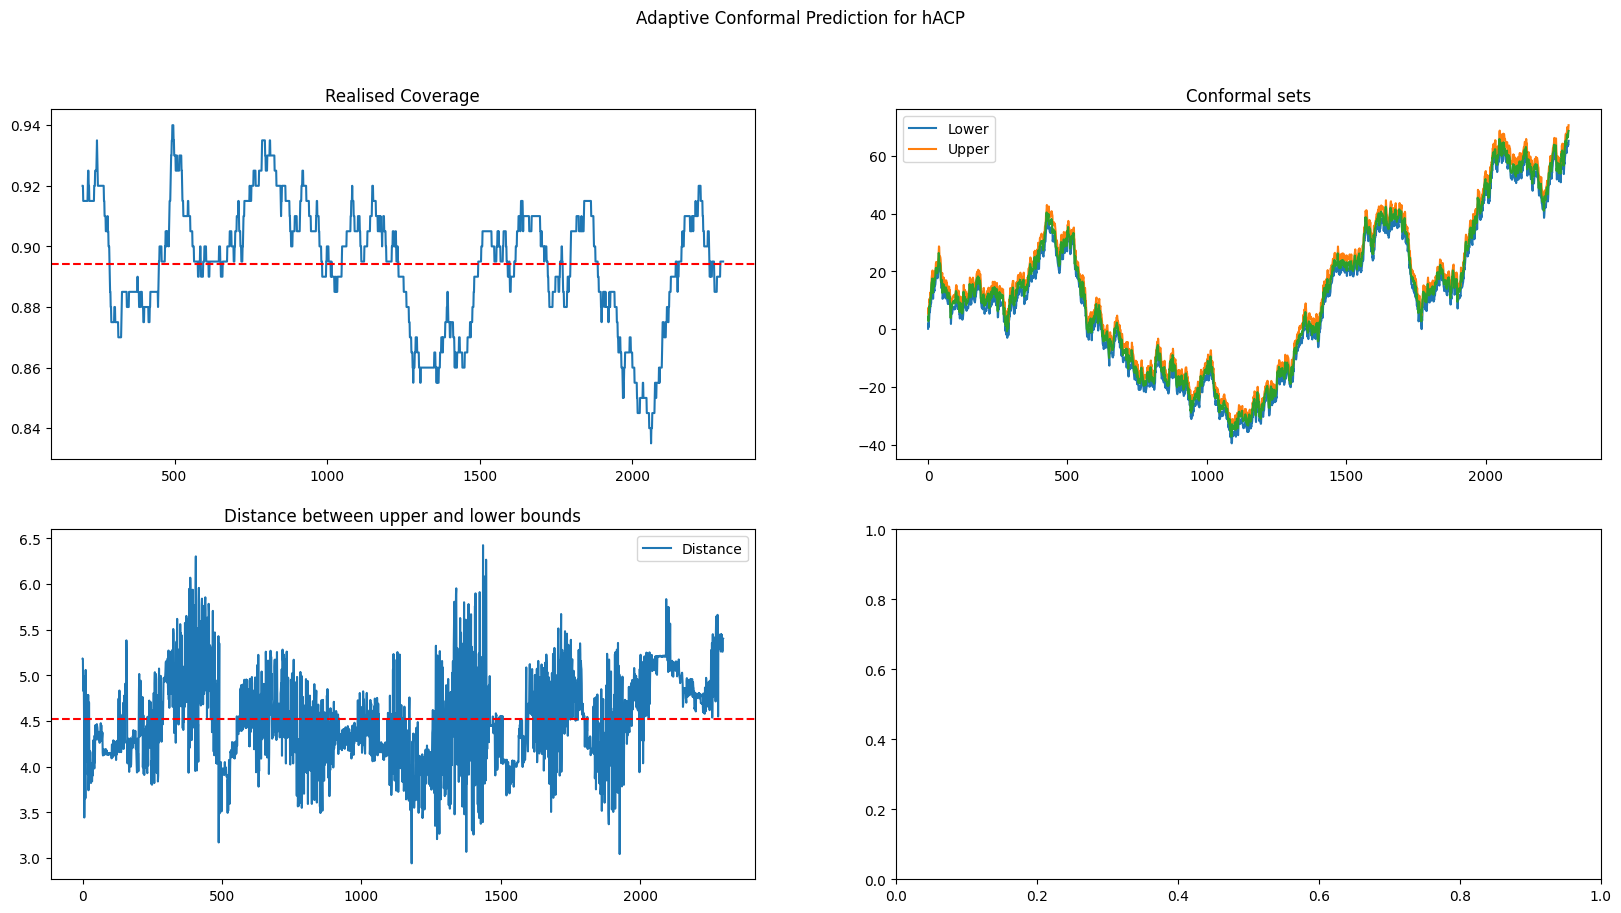

In [138]:
ACP_plots.one_plot(result, dataset[2])

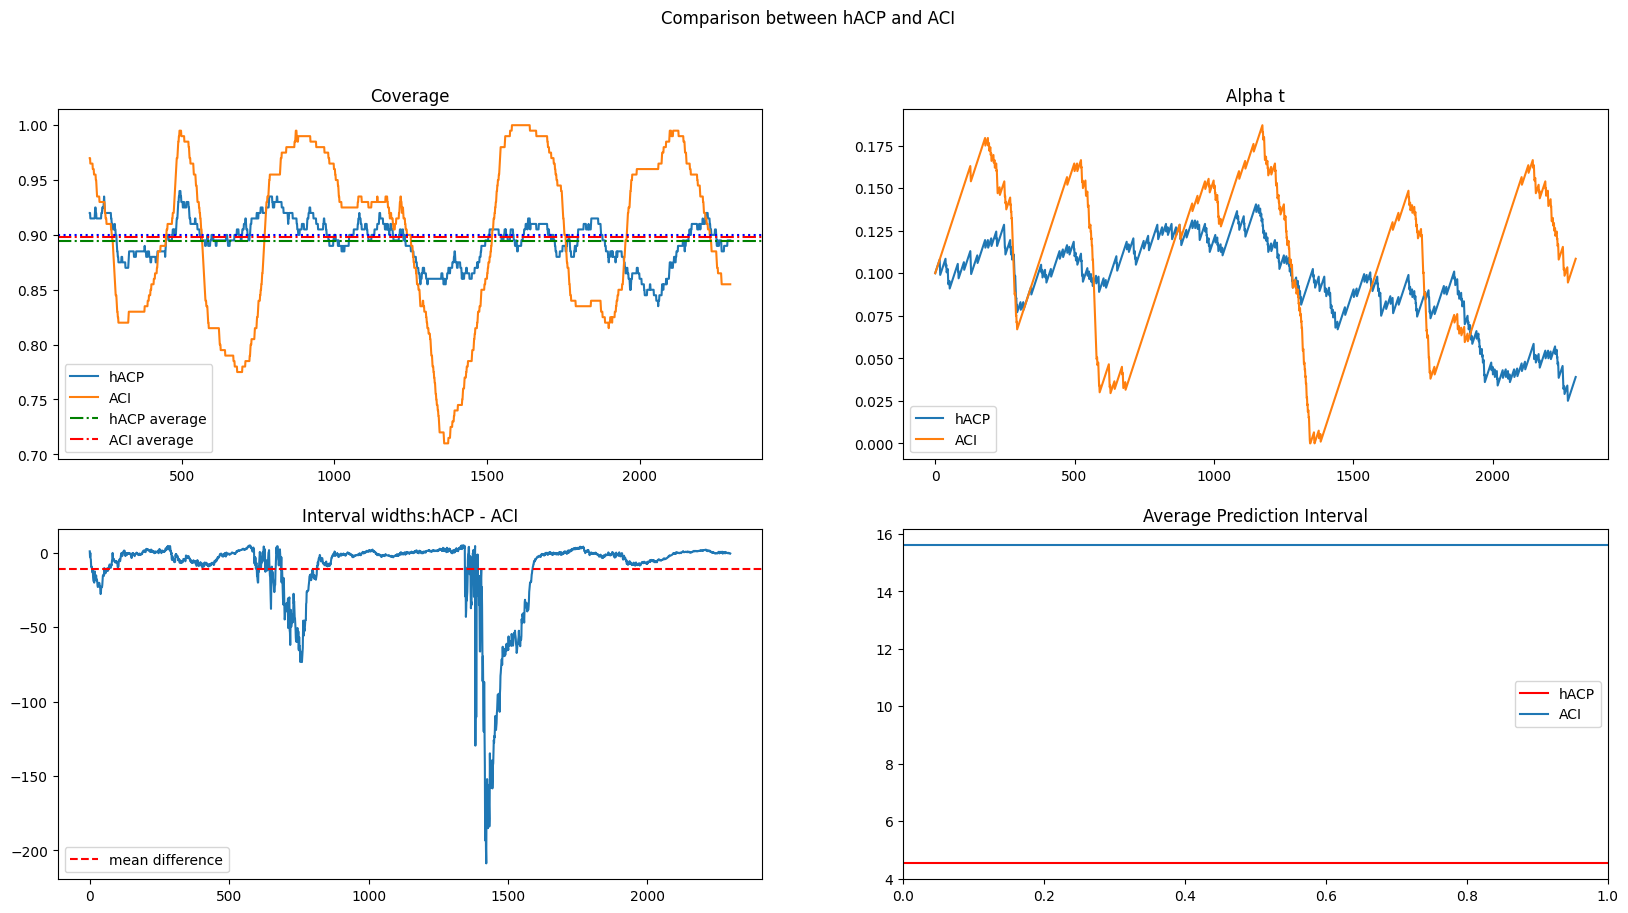

In [139]:
ACP_plots.compare_two(result, comparison, (20,10))

It doesnt converge to converge to the desired coverge. 
You are not testing it on hetroskedatic data.
- As the data is normal there should be significant alpha in knowing the variance ahead of time. 
- This effect does seem to be seen.
- There is significant periodicty in the method.

You shoudl test it on hetroskedatic data. This shoudlnt be too hard to do could do a random walk then just simulate error in the forecast as you have been doing. 

In [165]:
def create_hetroskedatic_cheb_data(length: int, model_error: float = 0.1, var_range: tuple = (0.5, 2)) -> tuple:
    '''Model error roughly corresponds to percentage uncertainty in the model.'''  
    minv, maxv = var_range

    # We will simulate a random walk for the variance. Might do a exponenital random walk as then no issues with negative values.

    exp_random_walk = np.random.normal(0, 0.1, length)
    true_variance_array = np.exp(np.cumsum(exp_random_walk))

    corresponding_normal = np.random.normal(0, true_variance_array, length)

    model_variance_array = true_variance_array + (true_variance_array * np.random.uniform(model_error, 2-model_error, length))
    time_series_normal = np.cumsum(corresponding_normal)

    # Now we need to return as xpred, varpred, y
    # The variance is the prediction for the same time step. 
    # Hence you need to ignore the first value for the variance as you do for the true value.

    return (time_series_normal[:-1], model_variance_array[1:], time_series_normal[1:])

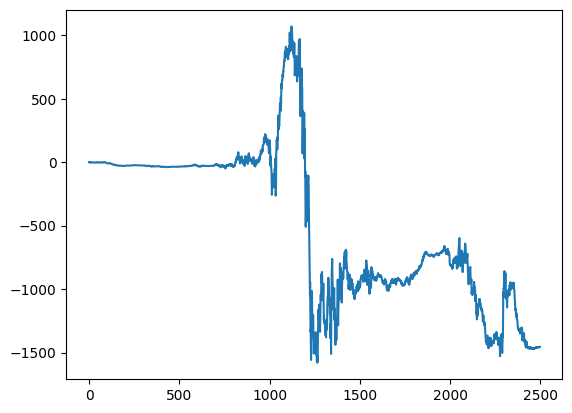

In [166]:
expdata = create_hetroskedatic_cheb_data(2500, model_error=0.1, var_range=(0.5, 2))
plt.plot(expdata[0])
plt.show()

Startpoint: 201


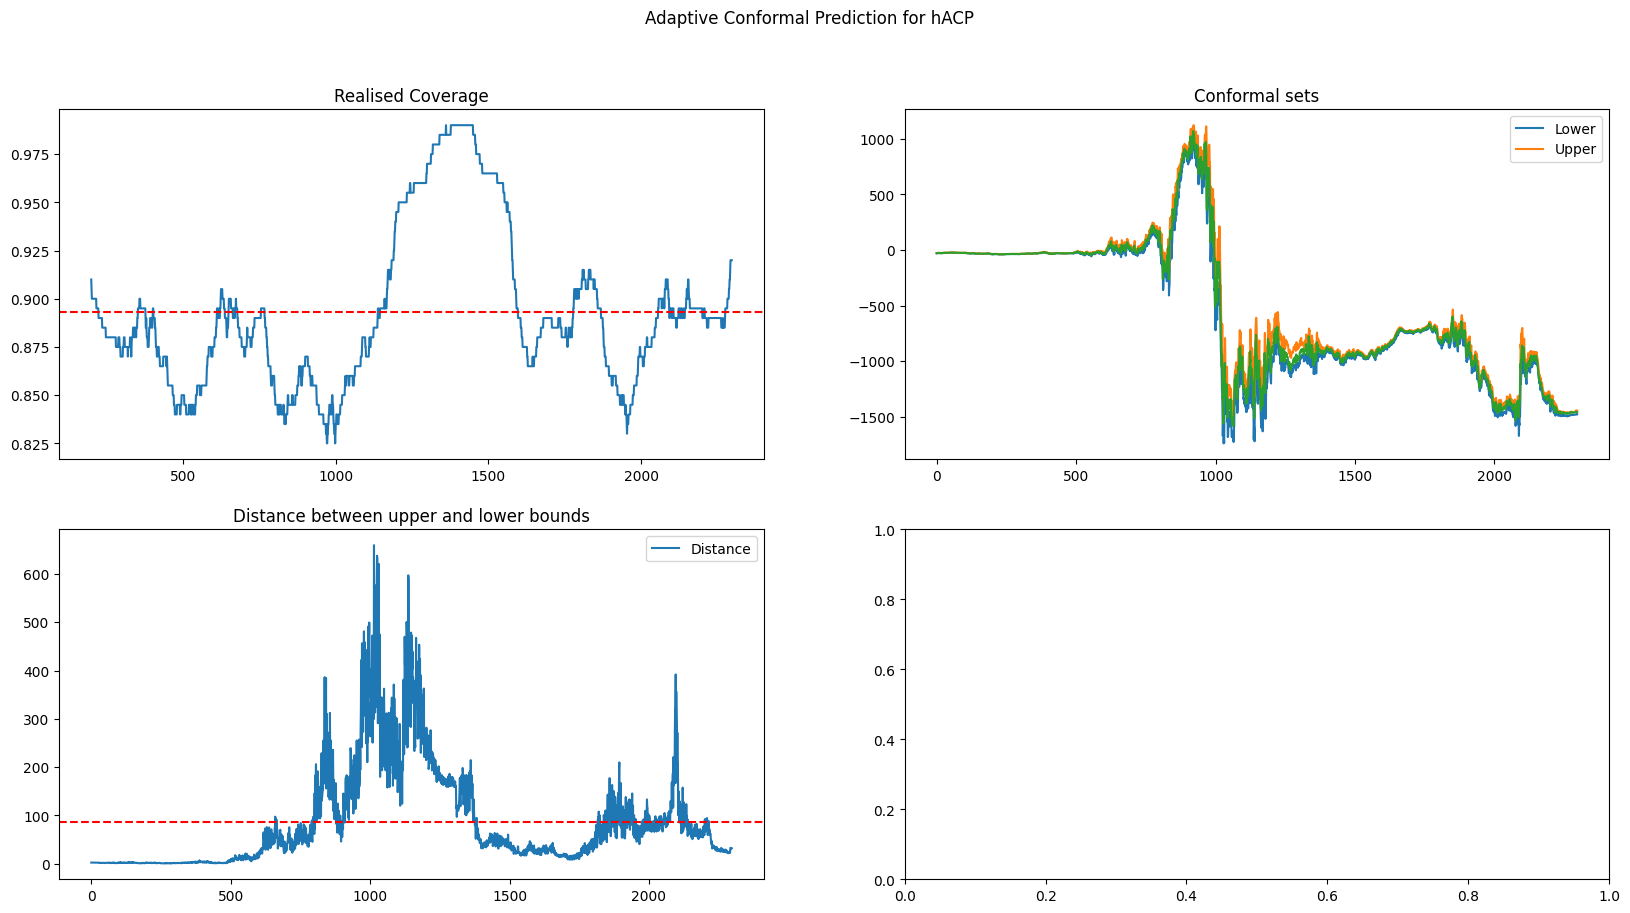

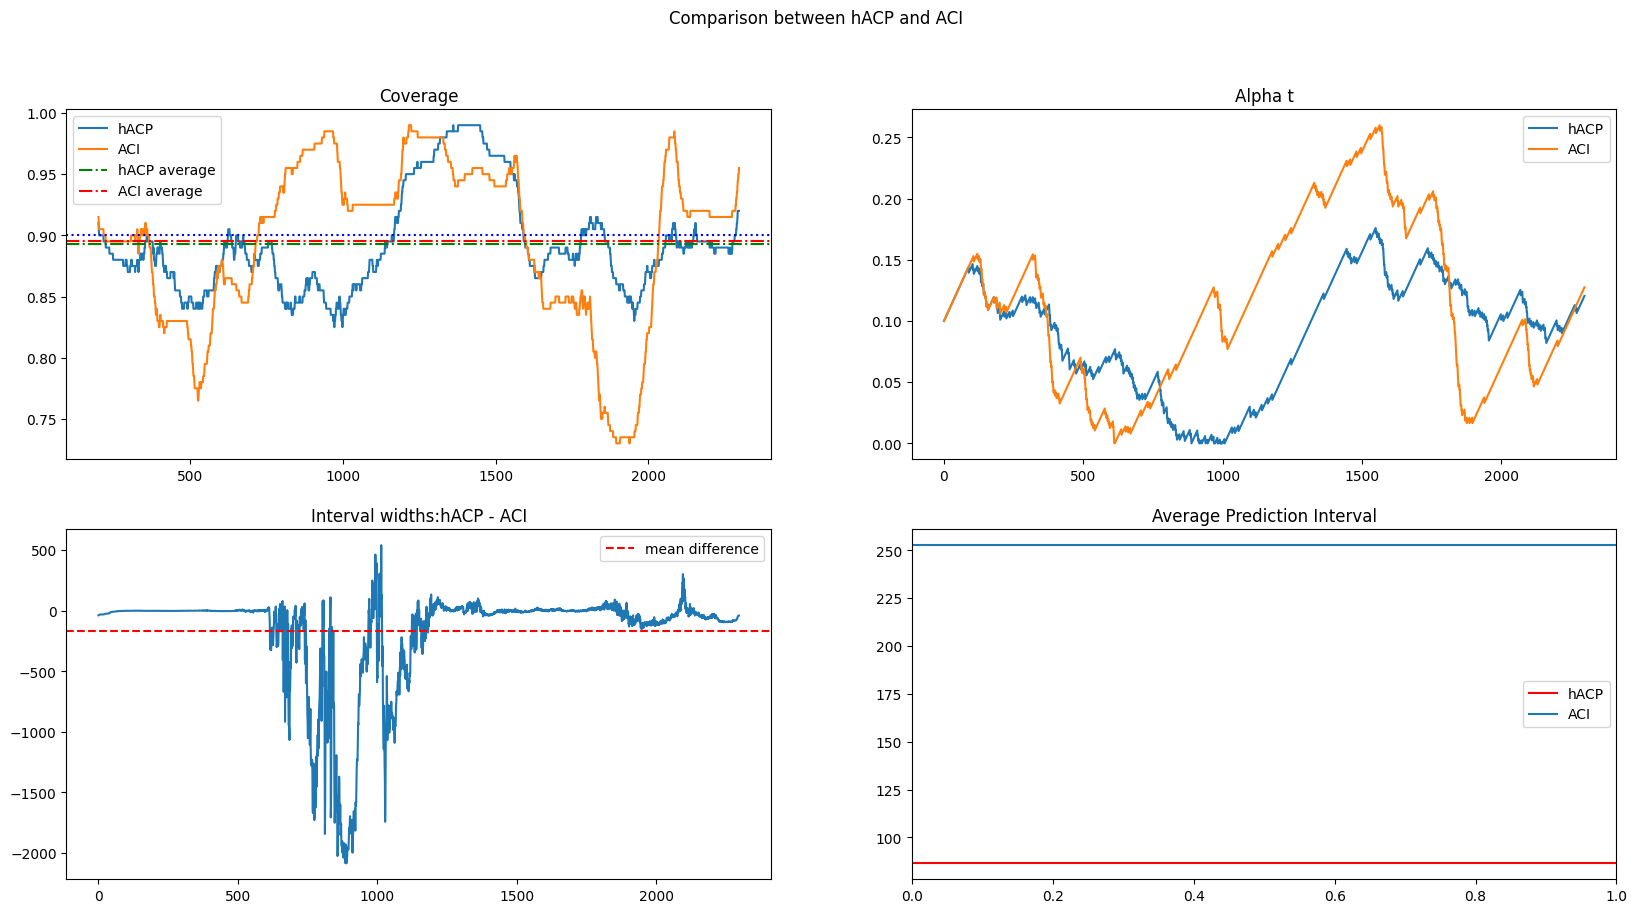

In [167]:
comparison = h.ACI((expdata[0], expdata[2]), 0.005, title='ACI', startpoint=201)
h = hACP(0.1, 200)
result = h.HACI(expdata, gamma=0.005, title='hACP')
ACP_plots.one_plot(result, expdata[2])
ACP_plots.compare_two(result, comparison, (20,10))

Below our variance model is bad but it can only under predict.

Startpoint: 201


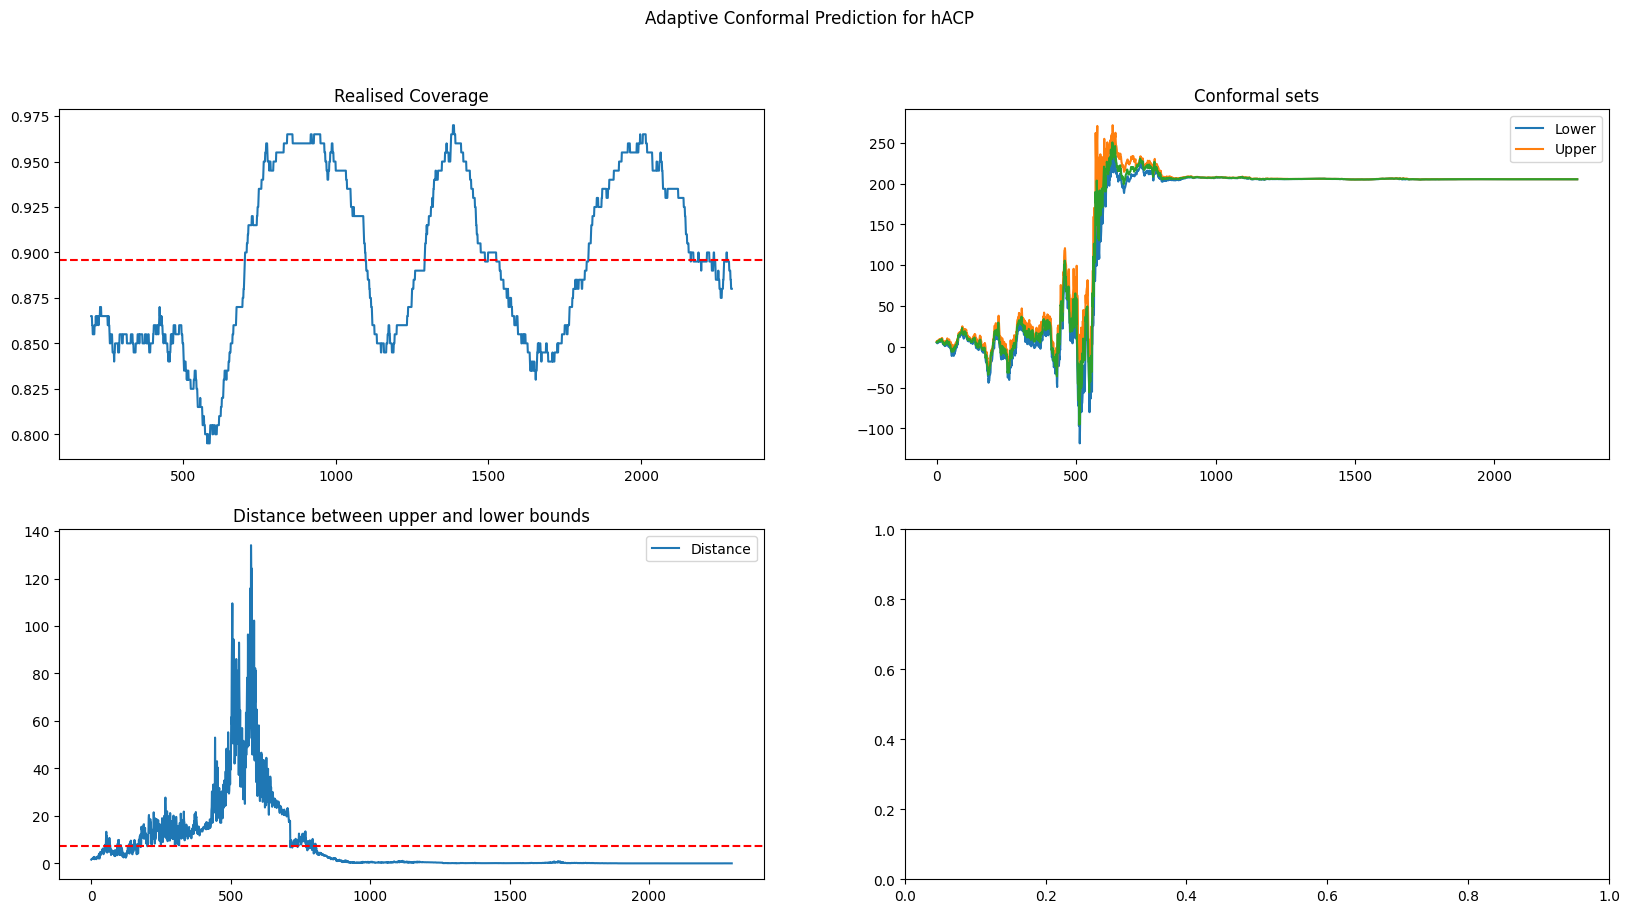

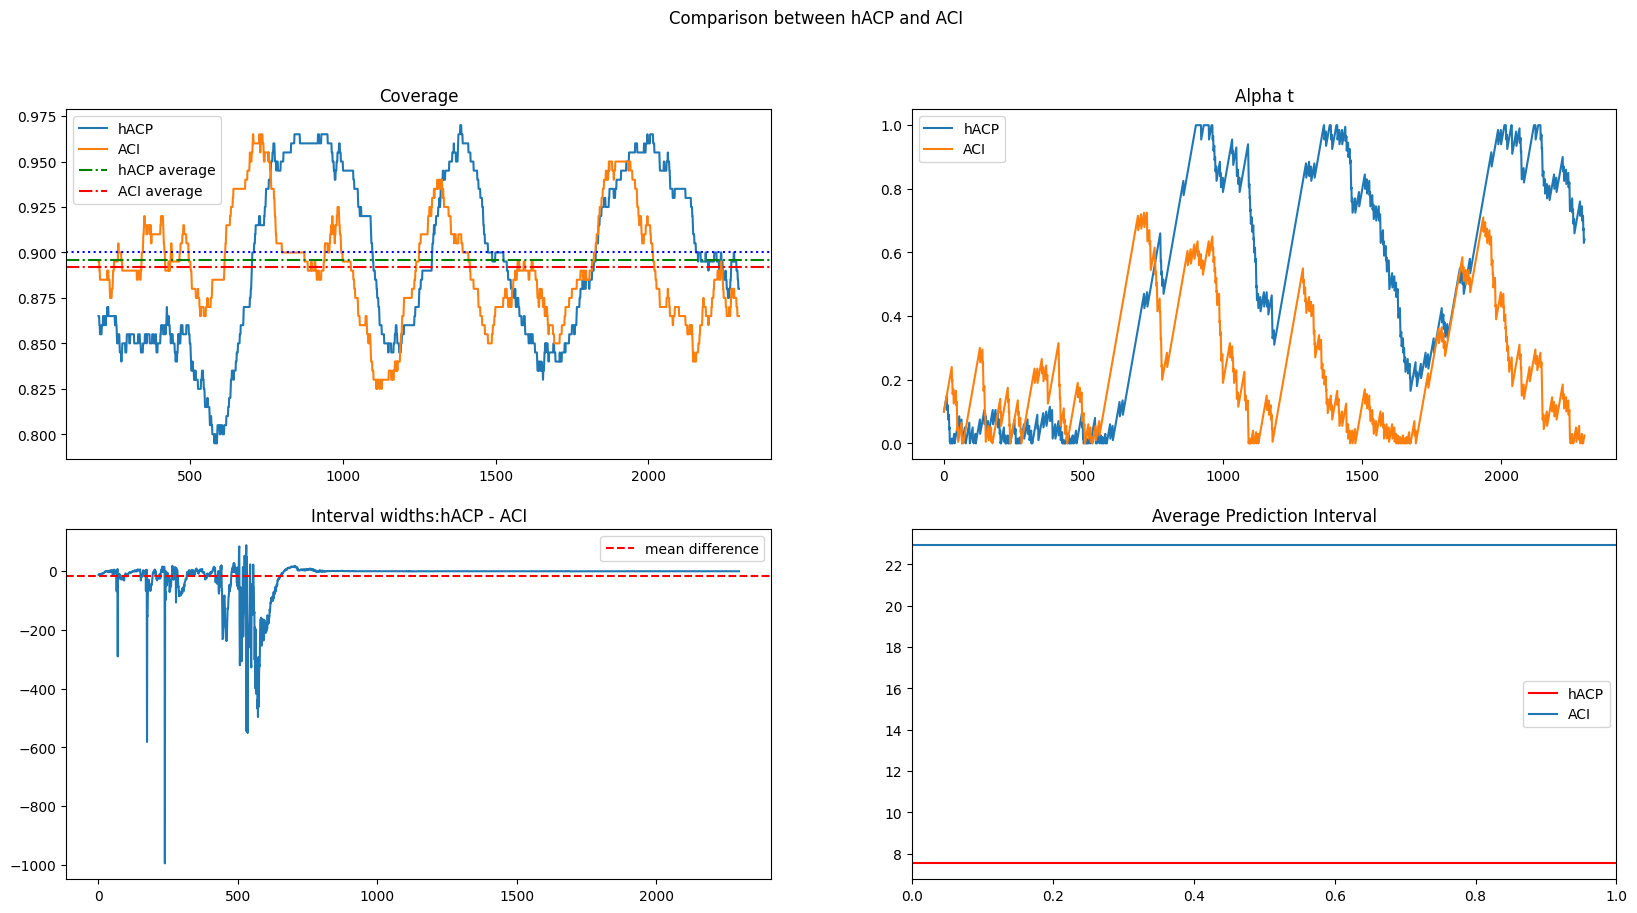

In [169]:
expdata = create_hetroskedatic_cheb_data(2500, model_error=0.0, var_range=(0.5, 2))
comparison = h.ACI((expdata[0], expdata[2]), 0.05, title='ACI', startpoint=201)
h = hACP(0.1, 200)
result = h.HACI(expdata, gamma=0.05, title='hACP', startpoint=1000)
ACP_plots.one_plot(result, expdata[2])
ACP_plots.compare_two(result, comparison, (20,10))

Looks like it is dominating. This isnt inheriently suprising as it has info. You should try an example where the model for variance is terrible.

Why is there so much less of the confomal sets? as opposed to the data.
- There is some form of glitch with startpoint which is prob true of the whole

# To make

- You should make methods for generating: exp random walk, with var. 
- Your hACI function is performant although it is still rough.
    - You need to sort out the start point issue.
- Create function that can turn any series into one that can be tested.
    - So use last val as xpred, then use the sample variance as the next guess.

# Intresting to test.
- Further compare the models against each other. 
- Would be interesting to see performance on stock data with a very simple volatility prediction method. 
    - Should it be possible that giving the sample second moment could improve the overal performance?
- Testing on a variety of data is vital. 

- Is there a good way to improve the optimisation.


In [214]:
# Creating code which will convert a sereis into a hACI sereis.

def xvy_from_y(series, lookback: int = -1):
    '''This function will create the x, var and y series from the y series.'''
    
    if lookback == -1:
        lookback = len(series) # This results in all data being used.

    x = series[:-1]
    y = series[1:]

    # Calculating the series of sample variances of a length lookback.
    var = [np.var(series[max(0, i - lookback):i+1]) for i in range(1, len(series))]

    return x, var, y

def xvy_from_ACP(dataset, lookback: int = -1):
    lookback = len(dataset) if lookback == -1 else lookback
    final = []
    for x, y in dataset:
        var = [np.var(x[max(0, i - lookback):i+1]) for i in range(1, len(x))] # We need to ignore the first value.
        final.append((x[1:], var, y[1:]))

    return final


In [234]:
all_stock_data = ACP_data.stock_data(100)

In [264]:
stock_data = [all_stock_data[4]]

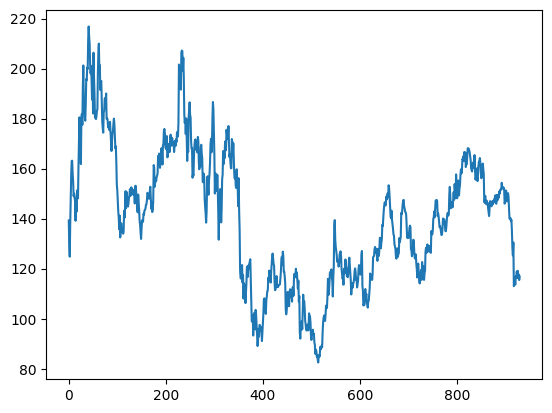

In [265]:
plt.plot(stock_data[0][1])

In [266]:
cleaned_stock_data = xvy_from_ACP(stock_data, 10)
print([len(x) for x in cleaned_stock_data[0]])


[929, 929, 929]


In [267]:
stock_result = h.HACI(cleaned_stock_data[0], gamma=0.02, title='hACP')


Startpoint: 201


In [268]:
corr_stock_data = (stock_data[0][0][1:], stock_data[0][1][1:])
comparison_result = h.ACI(corr_stock_data, 0.02, title='ACI')

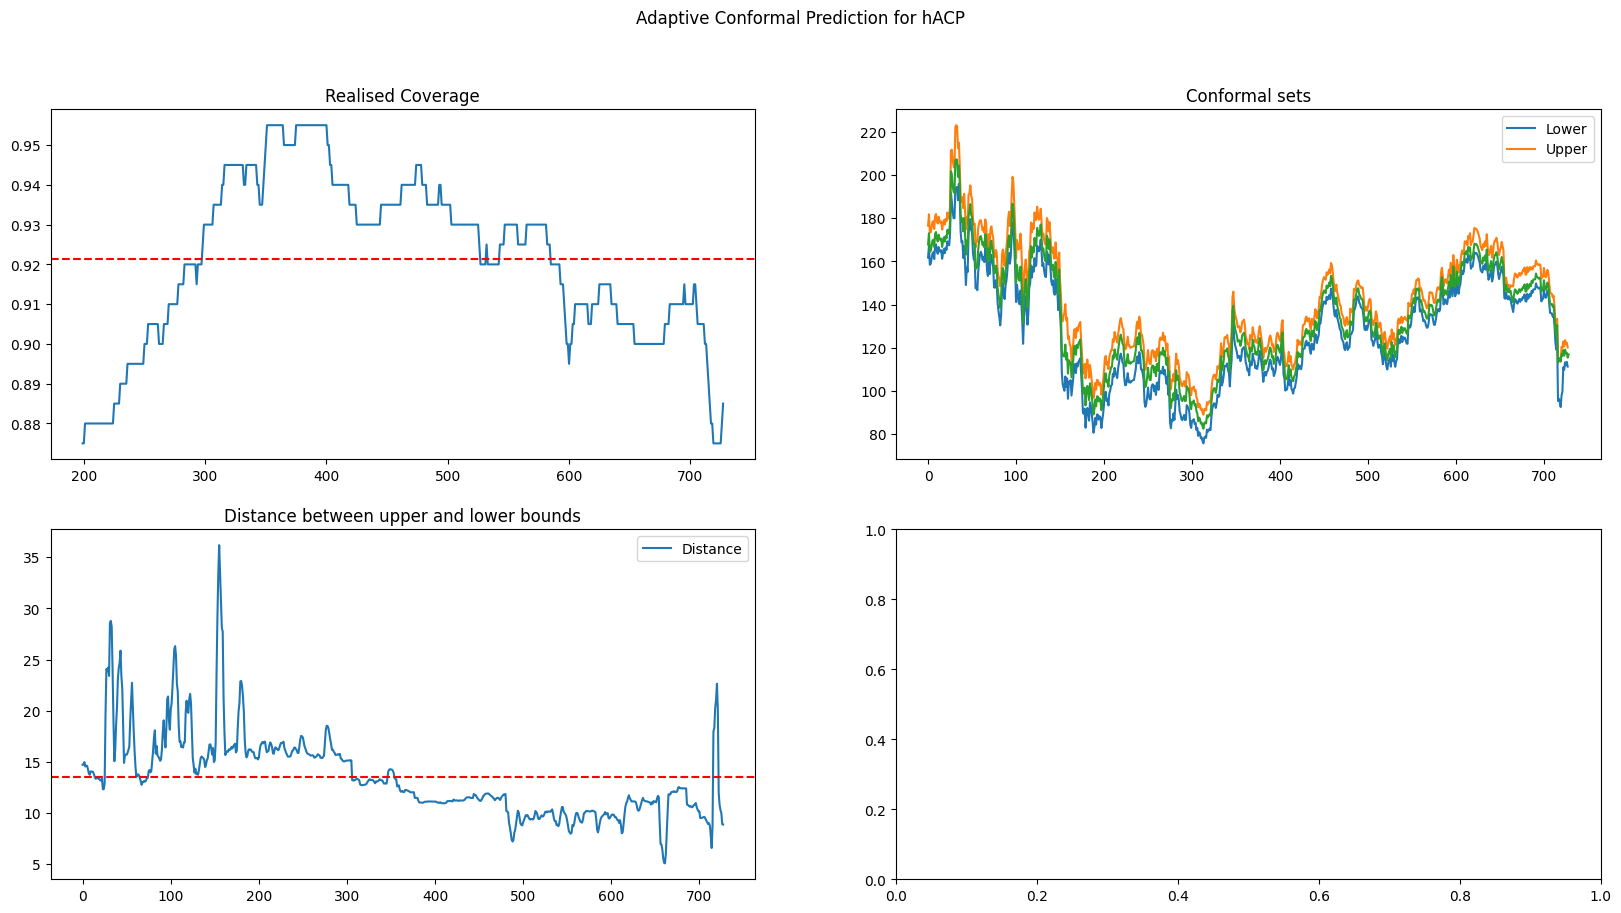

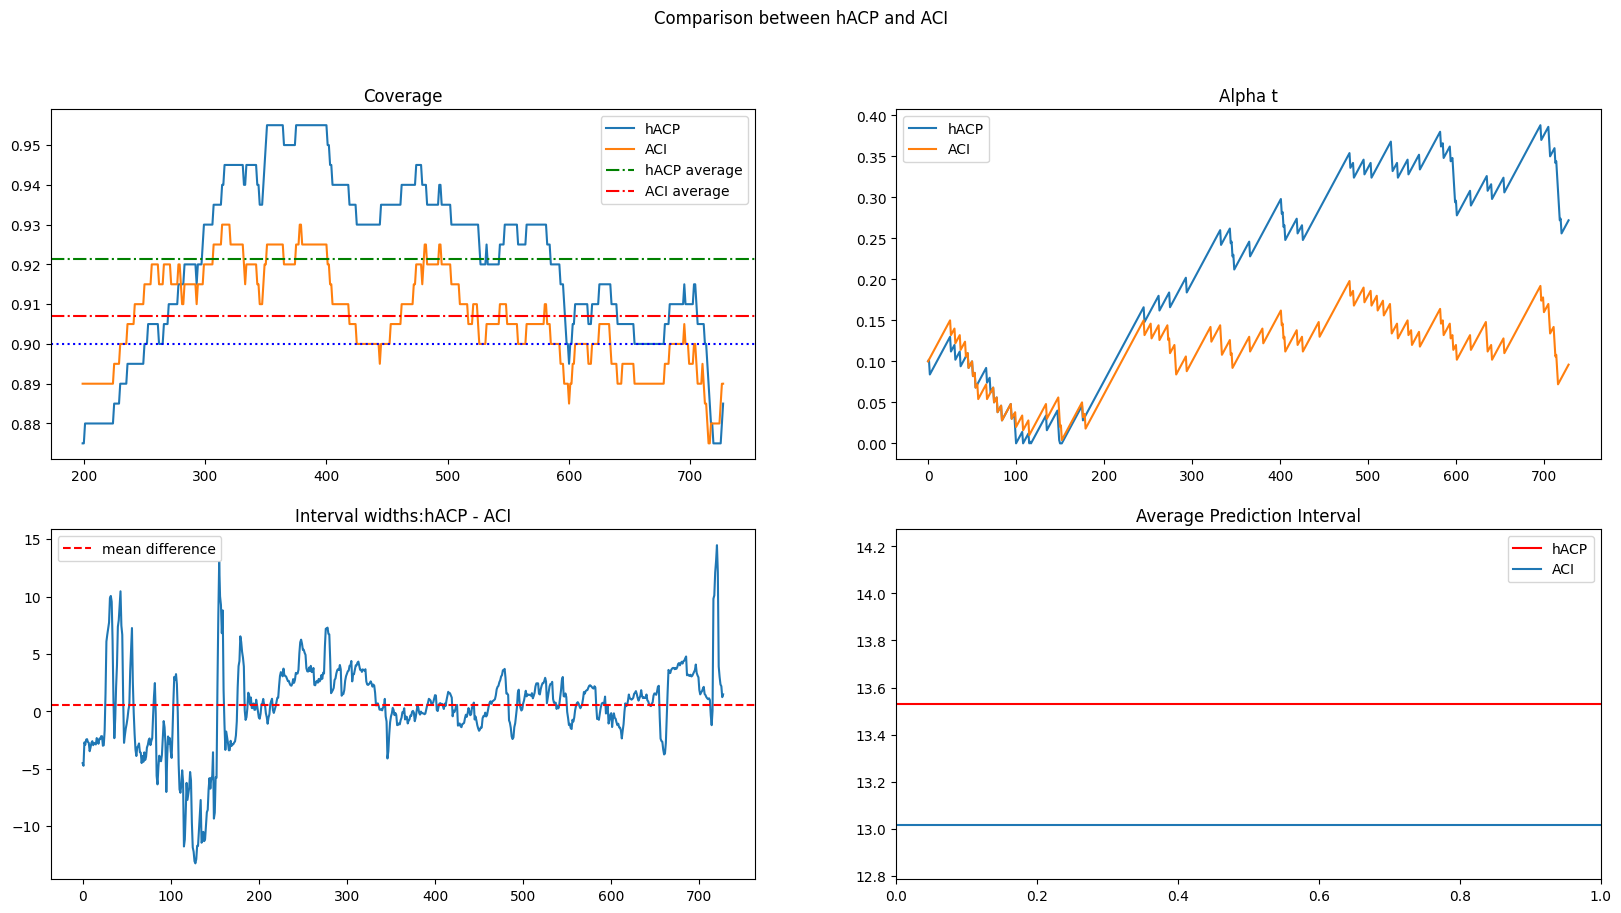

In [269]:
ACP_plots.one_plot(stock_result, stock_data[0][1])
ACP_plots.compare_two(stock_result, comparison_result, (20,10))

One issue is that your update should be dependent on whether it is above and below, you shoudl also make a method which doesnt make two estimates instead just makees the one.

Overal stop for today. Main takeaways:
- This method is working. It is getting near the target.
- Appears to ouperform in one specific scenario.
- Appears to lag in stock data with simple variance model.
